In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import  train_test_split
from scipy import stats
from sklearn import metrics
pd.set_option('display.max_rows',None) 
pd.set_option('display.max_columns',None)

In [2]:
def metrics_calculate(y, y_pred):
   tp = np.count_nonzero((y_pred == y) & (y == 1))
   fn = np.count_nonzero((y_pred != y) & (y == 1))
   tn = np.count_nonzero((y_pred == y) & (y == 0))
   fp = np.count_nonzero((y_pred != y) & (y == 0)) 
   tpr = tp / (tp + fn)
   spc = tn / (tn + fp)
   fpr = 1 - spc
   ppv = tp / (tp + fp)  
   npv = tn / (fn + tn)  

   return [tpr,spc,fpr,ppv,npv]

In [3]:
df = pd.read_excel('../../HT_data/HT_table_20240227_clean_final.xlsx', sheet_name='All_clean')
## convert mismatch < 0 -> = 0:
df['PWI-DWI Mismatch'][df['PWI-DWI Mismatch'] < 0] = 0 

features = ['NIHSS', 
            'ADC<620', 'Tmax>4 Volume', 'Tmax>6 Volume', 'Tmax>8 Volume', 'Tmax>10 Volume', 
            'PWI-DWI Mismatch', 'VTmax>10s/VTmax>6s']
X = df[features]
y = df['Group']
random_seed = 4 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
X_train.shape

/var/folders/ss/cyqt6ndd4fn7krhfng6_hjjc0000gn/T/ipykernel_2332/3536202919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PWI-DWI Mismatch'][df['PWI-DWI Mismatch'] < 0] = 0


(265, 8)

In [ ]:
# ['Age','Gender', 'Hypertension', 'Diabetes mellitus', 'Atrial fibrillation', 'Time from onset to MRI', 'NIHSS',
#        '$\mathrm{ADC} < 620 × \mathrm{10}^{-6} \mathrm{mm}^2/\mathrm{s}$', 'Tmax > 4 s', 'Tmax > 6 s', 'Tmax > 8 s',
#        'Tmax > 10 s', 'PWI-DWI mismatch', '$\mathrm{V_{Tmax>10s}}/\mathrm{V_{Tmax>6s}}$', 'Outcome (HT or non-HT)']

In [4]:
X_train = X_train.rename(columns={"NIHSS": "NIHSS score at admission",
    'ADC<620':'$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$',
                                  'Tmax>4 Volume':'Tmax > 4 s',
                                  'Tmax>6 Volume':'Tmax > 6 s',
                                  'Tmax>8 Volume':'Tmax > 8 s',
                                  'Tmax>10 Volume':'Tmax > 10 s',
                                  'PWI-DWI Mismatch':'PWI-DWI mismatch',
                                  'VTmax>10s/VTmax>6s':'HIR'})
X_train.head()

,NIHSS score at admission,$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$,Tmax > 4 s,Tmax > 6 s,Tmax > 8 s,Tmax > 10 s,PWI-DWI mismatch,HIR
220,0,8,385,155,63,21,147,0.1
259,3,52,139,92,68,49,40,0.5
119,22,116,804,489,304,213,373,0.4
364,1,0,12,0,0,0,0,0.0
378,3,0,38,9,9,9,9,1.0


In [5]:
X_test = X_test.rename(columns={"NIHSS": "NIHSS score at admission",
    'ADC<620':'$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$',
                                  'Tmax>4 Volume':'Tmax > 4 s',
                                  'Tmax>6 Volume':'Tmax > 6 s',
                                  'Tmax>8 Volume':'Tmax > 8 s',
                                  'Tmax>10 Volume':'Tmax > 10 s',
                                  'PWI-DWI Mismatch':'PWI-DWI mismatch',
                                  'VTmax>10s/VTmax>6s':'HIR'})
X_test.head()

,NIHSS score at admission,$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$,Tmax > 4 s,Tmax > 6 s,Tmax > 8 s,Tmax > 10 s,PWI-DWI mismatch,HIR
59,4,0,155,53,22,10,53,0.2
289,9,11,119,37,0,0,26,0.0
235,2,0,89,40,29,15,40,0.4
66,7,0,392,42,0,0,42,0.0
3,17,0,19,6,3,0,6,0.0


In [15]:
## sensitivity = tpr 
## 1-specificity = fpr 
def method_cutoff(X_train,y_train,feature_name,i):
     
    X_train_f = X_train[feature_name]
    
    colors = ['blue','orange','green','red','purple','brown','pink','gray']
    
    df_result = pd.DataFrame({'AUC':1,'Youden': 0,'Cutoff':0,'Acc':1,'SEN(Recall)':1,'SPC':0,'PPV(Precision)':1,'NPV':1},index=[feature_name])

    for cutoff in np.arange(np.min(X_train_f),np.max(X_train_f),0.01):
        cutoff = cutoff.round(4) 
        predictions = (X_train_f>cutoff).astype(int)
        auc = metrics.roc_auc_score(y_train,predictions).round(4)
        acc = metrics.accuracy_score(y_train,predictions).round(4)
        [tpr,spc,fpr,ppv,npv] = metrics_calculate(y_train,predictions)
        tmp = pd.DataFrame({'AUC':auc,'Youden':tpr-fpr,'Cutoff':cutoff,'Acc':acc,'SEN(Recall)':tpr,'SPC':spc,'PPV(Precision)':ppv,'NPV':npv},index=[feature_name])    
        df_result = pd.concat([df_result,tmp])
    
    
    max_youden = np.max(df_result['Youden'])
    cutoff_range = []
    zlist = []
    for z in range(len(df_result)):
        if df_result['Youden'][z] == max_youden:
            cutoff_range.append(df_result['Cutoff'][z])
            zlist.append(z)
    (ci_low,ci_high) = stats.t.interval(0.95, df=len(cutoff_range)-1, loc=np.mean(cutoff_range), scale=stats.sem(cutoff_range)) 
    cutoff = np.mean(cutoff_range)
    # print(df_result)
     

    X_test_f = X_test[feature_name]
    y_pred = (X_test_f>cutoff).astype(int)
    auc = metrics.roc_auc_score(y_test,y_pred).round(4)
    
    t = "%s \n (AUC = %.2f)"%(feature_name,auc)
    plt.plot(1-df_result['SPC'],df_result['SEN(Recall)'],linewidth=3,color = colors[i],label=t)
    plt.xlabel('1 - Specificity',fontsize=30,fontproperties = 'Times New Roman',fontweight = "bold")
    plt.ylabel('Sensitifity',fontsize=30,fontproperties = 'Times New Roman',fontweight = "bold")
    plt.legend(loc=4,prop={'size': 20,'family' : 'Times New Roman'})
    
    x = 1-df_result.iloc[zlist[0]]['SPC'] 
    y = df_result.iloc[zlist[0]]['SEN(Recall)'] 
    x_prime = 1-df_result.iloc[zlist[0]-1]['SPC'] 
    y_prime = df_result.iloc[zlist[0]-1]['SEN(Recall)'] 
    plt.arrow(x,y,(x_prime - x)/10,(y_prime - y)/10,width=0.006,fc=colors[i])
    print((x_prime - x,y_prime - y))
    
    return cutoff,(ci_low,ci_high)

In [12]:
features

Index(['NIHSS score at admission',
       '$\mathregular{ADC < 620 × 10^{-6} mm^2/s}$', 'Tmax > 4 s',
       'Tmax > 6 s', 'Tmax > 8 s', 'Tmax > 10 s', 'PWI-DWI mismatch', 'HIR'],
      dtype='object')

(0.6473988439306358, 0.06521739130434778)


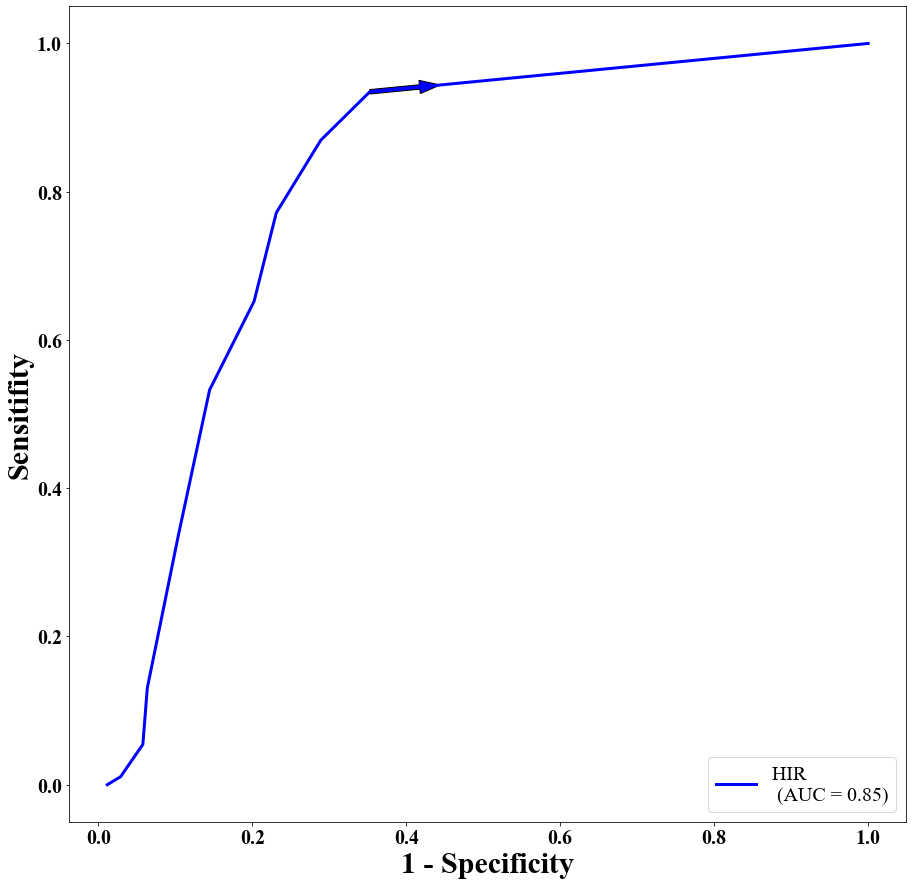

In [16]:
features = ['HIR'] # X_train.columns

plt.figure(figsize=(15,15))
cutoff_ls = dict() 
for i in range(len(features)):
    cutoff,(ci_low,ci_high) = method_cutoff(X_train,y_train,features[i],i)
    cutoff_ls[features[i]] = [cutoff,(ci_low,ci_high)]
plt.xticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")
plt.yticks(fontproperties = 'Times New Roman',fontsize=20,fontweight = "bold")
plt.savefig('figures/roc_curve.jpg',dpi=300)
plt.show()

In [17]:
cutoff_ls 

{'HIR': [0.045000000000000005, (0.023341494103866094, 0.06665850589613392)]}

In [10]:
def validate(X_test,y_test,feature_name,visbosity=True):
    cutoff = cutoff_ls[feature_name][0]
    X_test_f = X_test[feature_name]
    y_pred = (X_test_f>cutoff).astype(int)
    auc = metrics.roc_auc_score(y_test,y_pred).round(4)
    acc = metrics.accuracy_score(y_test,y_pred).round(4)
    [tpr,spc,fpr,ppv,npv] = metrics_calculate(y_test,y_pred)
    tmp = pd.DataFrame({'Cutoff':cutoff,'Cutoff 95%CI(low)':cutoff_ls[feature_name][1][0],'Cutoff 95%CI(high)':cutoff_ls[feature_name][1][1],'Acc':acc,'AUC':auc,'SEN(Recall)':tpr,'SPC':spc,'PPV(Precision)':ppv,'NPV':npv},index=[feature_name]) 
    if visbosity:
        cm = metrics.confusion_matrix(y_test,y_pred) 
        display = metrics.ConfusionMatrixDisplay(cm)
        display.plot(cmap=plt.cm.Blues)
        plt.title('{}:Test Result'.format(feature_name))
        plt.show()
    
    return tmp,y_pred  
        

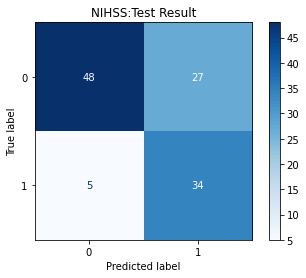

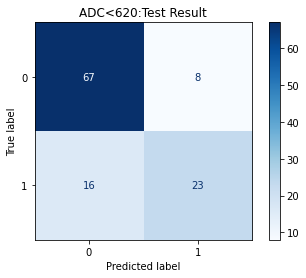

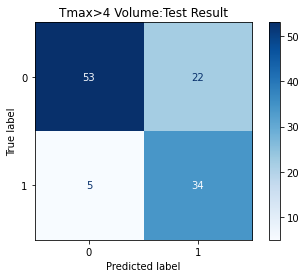

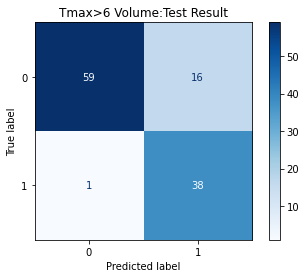

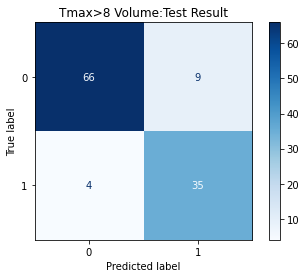

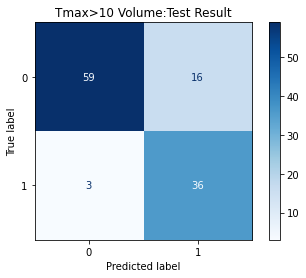

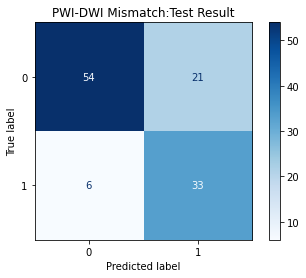

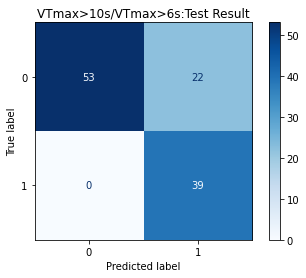

,Cutoff,Cutoff 95%CI(low),Cutoff 95%CI(high),Acc,AUC,SEN(Recall),SPC,PPV(Precision),NPV
NIHSS,5.495,5.4374,5.5526,0.7193,0.7559,0.8718,0.6400,0.5574,0.9057
ADC<620,18.495,18.4374,18.5526,0.7895,0.7415,0.5897,0.8933,0.7419,0.8072
Tmax>4 Volume,121.995,121.9143,122.0757,0.7632,0.7892,0.8718,0.7067,0.6071,0.9138
Tmax>6 Volume,45.495,45.4374,45.5526,0.8509,0.8805,0.9744,0.7867,0.7037,0.9833
Tmax>8 Volume,29.495,29.4374,29.5526,0.8860,0.8887,0.8974,0.8800,0.7955,0.9429
Tmax>10 Volume,9.495,9.4374,9.5526,0.8333,0.8549,0.9231,0.7867,0.6923,0.9516
PWI-DWI Mismatch,25.495,25.4374,25.5526,0.7632,0.7831,0.8462,0.7200,0.6111,0.9000
VTmax>10s/VTmax>6s,0.045,0.0233,0.0667,0.8070,0.8533,1.0000,0.7067,0.6393,1.0000


In [11]:
test_result = pd.DataFrame(columns=['Cutoff','Cutoff 95%CI(low)','Cutoff 95%CI(high)','Acc','AUC','SEN(Recall)','SPC','PPV(Precision)','NPV'])
for i in range(len(features)):
    rst,_ = validate(X_test,y_test,features[i])
    test_result = pd.concat([test_result,rst.round(4)])
test_result

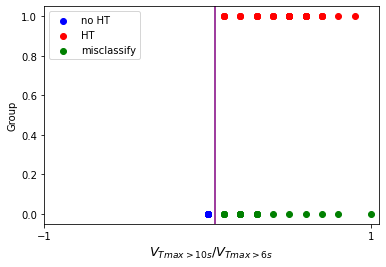

In [19]:
## visualization of volume ratio 
feature_name = 'VTmax>10s/VTmax>6s'
feature_ls = X_test[feature_name]
_,y_pred = validate(X_test,y_test,feature_name,visbosity=False)
cutoff = cutoff_ls[feature_name][0]
ht_feature = feature_ls[y_test[(y_test == 1) & (y_test == y_pred)].index ]
noht_feature = feature_ls[y_test[(y_test == 0) & (y_test == y_pred)].index]
misclassify_feature = feature_ls[y_test[y_test != y_pred].index]
y_ht = y_test[(y_test == 1) & (y_test == y_pred)]
y_noht = y_test[(y_test == 0) & (y_test == y_pred)]
y_misclassify = y_test[y_test!=y_pred]

plt.scatter(noht_feature,y_noht,label='no HT',c='blue')
plt.scatter(ht_feature,y_ht,label='HT',c='red')
plt.scatter(misclassify_feature,y_misclassify,label='misclassify',c='green')
plt.axvline(cutoff,color='purple')
plt.xticks([-1,1])
plt.xlabel('$V_{Tmax>10s}$/$V_{Tmax>6s}$',fontsize=13)
plt.ylabel('Group')
plt.legend()
plt.show()

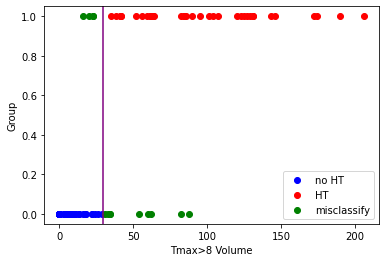

In [10]:
## visualization of volume ratio 
feature_name = 'Tmax>8 Volume'
feature_ls = X_test[feature_name]
_,y_pred = validate(X_test,y_test,feature_name,visbosity=False)
cutoff = cutoff_ls[feature_name][0]
ht_feature = feature_ls[y_test[(y_test == 1) & (y_test == y_pred)].index ]
noht_feature = feature_ls[y_test[(y_test == 0) & (y_test == y_pred)].index]
misclassify_feature = feature_ls[y_test[y_test != y_pred].index]
y_ht = y_test[(y_test == 1) & (y_test == y_pred)]
y_noht = y_test[(y_test == 0) & (y_test == y_pred)]
y_misclassify = y_test[y_test!=y_pred]

plt.scatter(noht_feature,y_noht,label='no HT',c='blue')
plt.scatter(ht_feature,y_ht,label='HT',c='red')
plt.scatter(misclassify_feature,y_misclassify,label='misclassify',c='green')
plt.axvline(cutoff,color='purple')
plt.xlabel(feature_name)
plt.ylabel('Group')
plt.legend()